<a href="https://colab.research.google.com/github/Aestivation/DL2025-Labs/blob/main/CNN_With_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4 – CNNs and Transfer Learning

This notebook strictly follows the lab instructions.

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds

## Convolution and Pooling
Why: to visualize feature extraction and spatial reduction.

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


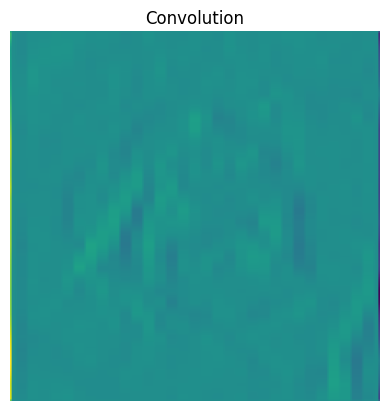

In [3]:

(img_train, _), _ = keras.datasets.cifar10.load_data()
img = tf.image.resize(img_train[0], (224,224))
img = tf.expand_dims(tf.cast(img, tf.float32), axis=0)

kernel = tf.constant([[-1,0,1],[-1,0,1],[-1,0,1]], dtype=tf.float32)
kernel = tf.reshape(kernel, (3,3,1,1))
kernel = tf.repeat(kernel, 3, axis=2)

conv = tf.nn.conv2d(img, kernel, 1, "SAME")
max_pool = tf.nn.max_pool2d(conv, 2, 2, "SAME")

plt.imshow(conv[0]/255); plt.title("Convolution"); plt.axis("off")
plt.show()


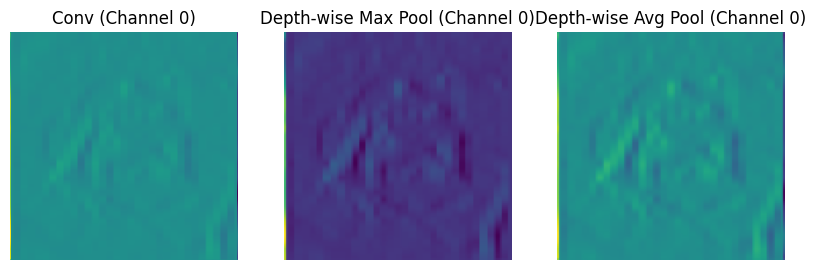

In [4]:
#  Depth-wise pooling demonstration
# Pooling is applied independently on each channel
max_pool = tf.nn.max_pool2d(conv, 2, 2, "SAME")
avg_pool = tf.nn.avg_pool2d(conv, 2, 2, "SAME")


# Select one channel to visualize (e.g. channel 0)
conv_ch0 = conv[0, :, :, 0]
maxpool_ch0 = max_pool[0, :, :, 0]
avgpool_ch0 = avg_pool[0, :, :, 0]

plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.title("Conv (Channel 0)")
plt.imshow(conv_ch0 / 255)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Depth-wise Max Pool (Channel 0)")
plt.imshow(maxpool_ch0 / 255)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Depth-wise Avg Pool (Channel 0)")
plt.imshow(avgpool_ch0 / 255)
plt.axis("off")

plt.show()


## CNN on Fashion-MNIST
Why: baseline image classifier.

In [ ]:

(x_train,y_train),(x_test,y_test)=keras.datasets.fashion_mnist.load_data()
x_train=x_train/255.0

model = keras.Sequential([
    keras.layers.Input(shape=(28,28)),
    keras.layers.Reshape((28,28,1)),
    keras.layers.Conv2D(32,3,activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(10,activation='softmax')
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(x_train,y_train,epochs=3,validation_split=0.1)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.7845 - loss: 0.6166 - val_accuracy: 0.8775 - val_loss: 0.3538
Epoch 2/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.8852 - loss: 0.3350 - val_accuracy: 0.8920 - val_loss: 0.3049
Epoch 3/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - accuracy: 0.8957 - loss: 0.2946 - val_accuracy: 0.8972 - val_loss: 0.2957


## Transfer Learning with Xception
Why: reuse ImageNet-trained generic features.

In [ ]:

(ds_train,ds_val,_),_=tfds.load(
    "tf_flowers",
    split=["train[:70%]","train[70%:85%]","train[85%:]"],
    as_supervised=True,
    with_info=True
)

def preprocess(img,label):
    img=tf.image.resize(img,(299,299))
    img=keras.applications.xception.preprocess_input(img)
    return img,label

train_ds=ds_train.map(preprocess).batch(32)
val_ds=ds_val.map(preprocess).batch(32)

base_model=keras.applications.Xception(weights="imagenet",include_top=False)
base_model.trainable=False

model=keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(5,activation='softmax')
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(train_ds,validation_data=val_ds,epochs=3)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.Z4SLT8_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/3
81/81 ━━━━━━━━━━━━━━━━━━━━ 1305s 16s/step - accuracy: 0.6628 - loss: 1.0327 - val_accuracy: 0.8730 - val_loss: 0.4519
Epoch 2/3
81/81 ━━━━━━━━━━━━━━━━━━━━ 1256s 16s/step - accuracy: 0.8760 - loss: 0.4170 - val_accuracy: 0.8947 - val_loss: 0.3489
Epoch 3/3
81/81 ━━━━━━━━━━━━━━━━━━━━ 1279s 16s/step - accuracy: 0.9050 - loss: 0.3257 - val_accuracy: 0.9002 - val_loss: 0.3077


## ResNet
Why: demonstrate residual connections.

In [ ]:
keras.applications.ResNet50(weights=None).summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)